##Load Library

In [ ]:
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import f1_score, make_scorer,accuracy_score, classification_report, recall_score, precision_score
from sklearn.multiclass import OneVsRestClassifier

import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

In [ ]:
import pandas as pd
import numpy as np
import os

In [ ]:
!pip install Sastrawi

In [ ]:
import Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

import string 
import re

import nltk
nltk.download('punkt')

from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

%matplotlib inline
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from html import unescape, escape
from nltk.stem import PorterStemmer 

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
##skip "Load Dataset" if you want to use dataset from github

##Load Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip "/content/drive/My Drive/Dataset/Label2.zip"

Archive:  /content/drive/My Drive/Dataset/Label2.zip
   creating: Label2/
  inflating: Label2/labeling_Lipstick_Anastasia Beverly Hills_1877.0.txt.xlsx  
  inflating: Label2/labeling_Lipstick_Anastasia Beverly Hills_1879.0.txt.xlsx  
  inflating: Label2/labeling_Lipstick_Anastasia Beverly Hills_1883.0.txt.xlsx  
  inflating: Label2/labeling_Lipstick_Anastasia Beverly Hills_1884.0.txt.xlsx  
  inflating: Label2/labeling_Lipstick_Anastasia Beverly Hills_1889.0.txt.xlsx  
  inflating: Label2/labeling_Lipstick_Anastasia Beverly Hills_1892.0.txt.xlsx  
  inflating: Label2/labeling_Lipstick_Anastasia Beverly Hills_2050.0.txt.xlsx  
  inflating: Label2/labeling_Lipstick_Anastasia Beverly Hills_2363.0.txt.xlsx  
  inflating: Label2/labeling_Lipstick_Anastasia Beverly Hills_2369.0.txt.xlsx  
  inflating: Label2/labeling_Lipstick_Australis_1059.0.txt.xlsx  
  inflating: Label2/labeling_Lipstick_Australis_1921.0.txt.xlsx  
  inflating: Label2/labeling_Lipstick_Australis_6202.0.txt.xlsx  
  inflat

In [4]:
np.random.seed(0)

In [5]:
files = os.listdir('Label2')
li = []
for filename in files:
    df = pd.read_excel("/content/Label2/"+format(filename))
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

In [6]:
df

review_id  sent_nb  ... aroma_pattern_label aroma_human_label
0          1450        1  ...             unknown           unknown
1          1450        2  ...             unknown           unknown
2          1450        3  ...             unknown           unknown
3          1450        4  ...             unknown           unknown
4          1450        5  ...             unknown               pos
...         ...      ...  ...                 ...               ...
2590       7979       17  ...             unknown           unknown
2591       7979       18  ...             unknown           unknown
2592       7979       19  ...             unknown           unknown
2593       7979       20  ...             unknown           unknown
2594       7979       21  ...             unknown           unknown

[2595 rows x 17 columns]

In [7]:
human_col = ['price_human_label', 'packaging_human_label', 'color_human_label', 'pigmented_human_label', 'staying_power_human_label', 'moist_human_label', 'aroma_human_label']

In [8]:
df_human = df[~((df[human_col] == 'unknown').all(axis=1))]

In [9]:
df_human.head()

review_id  sent_nb  ... aroma_pattern_label aroma_human_label
2       1450        3  ...             unknown           unknown
3       1450        4  ...             unknown           unknown
4       1450        5  ...             unknown               pos
6       2209        7  ...             unknown           unknown
8       2209        9  ...             unknown           unknown

[5 rows x 17 columns]

In [10]:
df_human.tail()

review_id  sent_nb  ... aroma_pattern_label aroma_human_label
2587       6514       14  ...             unknown           unknown
2590       7979       17  ...             unknown           unknown
2591       7979       18  ...             unknown           unknown
2592       7979       19  ...             unknown           unknown
2594       7979       21  ...             unknown           unknown

[5 rows x 17 columns]

In [57]:
df_human.shape

(1403, 17)

#Preprocessing

In [62]:
#uncomment this to use dataset from github
# url = 'https://raw.githubusercontent.com/syitilv/ABSA-Beauty-Product/master/Dataset/df_human.csv'
# df_human = pd.read_csv(url, error_bad_lines=False)

In [16]:
df_review_human = df_human.drop(['review_id','sent_nb','price_pattern_label', 'packaging_pattern_label', 'color_pattern_label', 'pigmented_pattern_label', 'staying_power_pattern_label', 'moist_pattern_label', 'aroma_pattern_label'], axis=1)

In [17]:
df_review_human

reviee_sent  ... aroma_human_label
2     dipulas beberapa kali juga tidak membawa perbe...  ...           unknown
3     produk ini tidak bikin bibir kering, sih, di s...  ...           unknown
4     saat dipakai juga tidak ada bau atau rasa tert...  ...               pos
6     mulai dari packagingnya yg slim dan good looki...  ...           unknown
8     ngelembabin bibir untuk 2 jam pertama, habis i...  ...           unknown
...                                                 ...  ...               ...
2587                               worth the price lah.  ...           unknown
2590  tapi lama-lama bosen juga, terus nyoba rebel i...  ...           unknown
2591  yang paling bikin aku suka adalah awetnya, dip...  ...           unknown
2592  tapi saking awetnya ngapusnya juga harus pake ...  ...           unknown
2594  buat liquid lipstik yang harganya jauh lebih m...  ...           unknown

[1403 rows x 8 columns]

##EDA

In [18]:
counts_human = []
for i in human_col:
    counts_human.append((i, (df_human[i]!='unknown').sum()))
df_stats_human = pd.DataFrame(counts_human, columns=['category', 'number_of_review'])

In [19]:
df_stats_human

category  number_of_review
0          price_human_label               123
1      packaging_human_label               127
2          color_human_label               550
3      pigmented_human_label               222
4  staying_power_human_label               355
5          moist_human_label               316
6          aroma_human_label               108

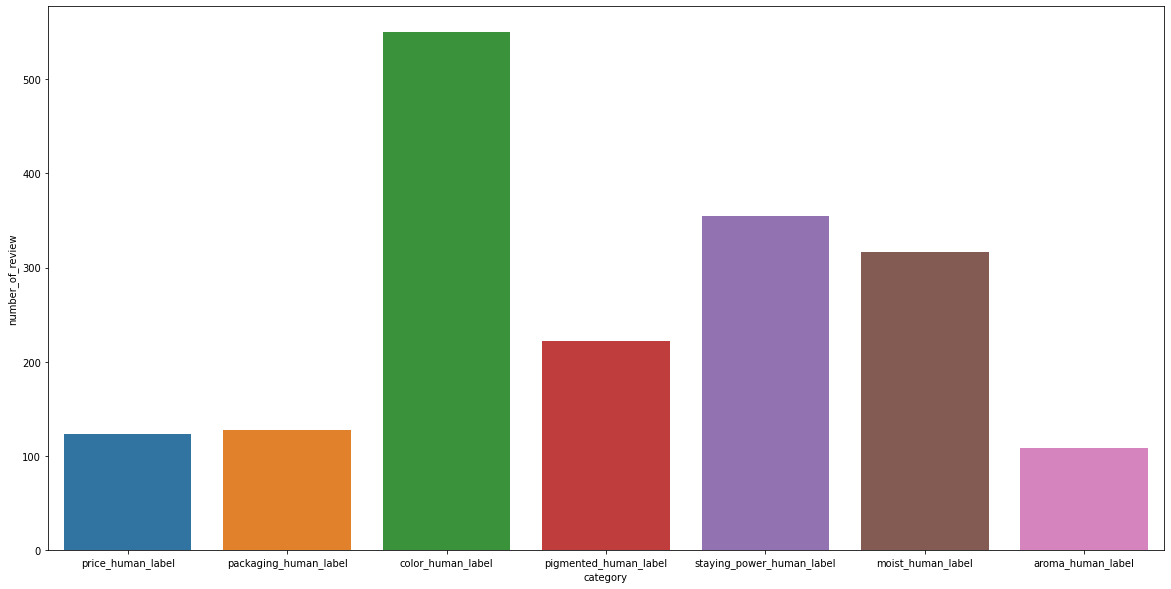

In [20]:
_,ax= plt.subplots(figsize=(20,10))
sns.barplot(data=df_stats_human,x='category', y='number_of_review')

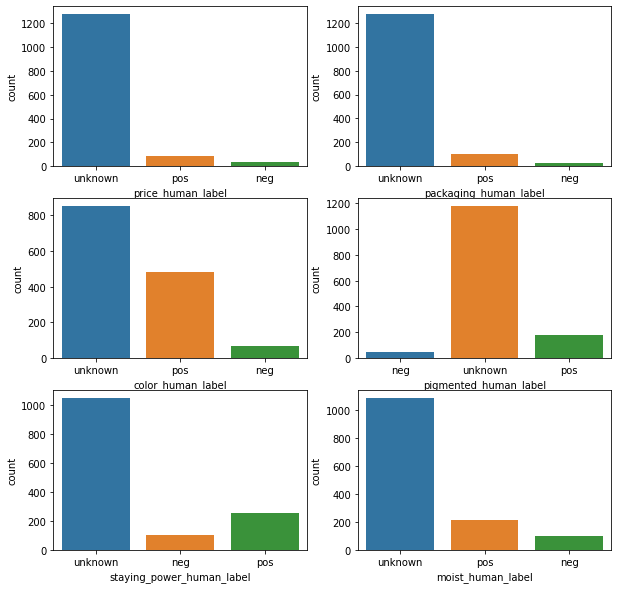

In [21]:
plt.figure(figsize=(10,10))
for n in range(6):
  ax = plt.subplot(3,2,n+1)
  sns.countplot(x=human_col[n],data=df_human,ax=ax)

In [22]:
listDrop = [x for x in df_review_human.columns if '_enc' in x]
listDrop

[]

In [23]:
df_test = df_review_human.melt(id_vars=["reviee_sent"], 
        var_name="aspect", 
        value_name="polarity")

In [24]:
df_graph = df_test.groupby(['aspect','polarity']).count().reset_index()

In [25]:
df_graph = df_graph.replace({'aroma_human_label': 'Smell', 
                  'color_human_label': 'Color',
                  'moist_human_label': 'Moisture', 
                  'packaging_human_label': 'Packaging',
                  'pigmented_human_label': 'Pigment',
                  'price_human_label': 'Price',
                  'staying_power_human_label': 'Staying Power'})

In [26]:
df_graph = df_graph[~df_graph['aspect'].str.contains('_enc')]

In [27]:
df_graph

aspect polarity  reviee_sent
0           Smell      neg           59
1           Smell      pos           49
2           Smell  unknown         1295
3           Color      neg           68
4           Color      pos          482
5           Color  unknown          853
6        Moisture      neg          100
7        Moisture      pos          216
8        Moisture  unknown         1087
9       Packaging      neg           25
10      Packaging      pos          102
11      Packaging  unknown         1276
12        Pigment      neg           44
13        Pigment      pos          178
14        Pigment  unknown         1181
15          Price      neg           36
16          Price      pos           87
17          Price  unknown         1280
18  Staying Power      neg          100
19  Staying Power      pos          255
20  Staying Power  unknown         1048

In [28]:
import plotly.express as px

fig = px.bar(df_graph, x="aspect", y="reviee_sent", color="polarity",barmode="group",
             labels={
                     "reviee_sent": "Review Sentence",
                     "aspect": "Aspect",
                     "polarity": "Polarity"
                 })

fig.update_layout(
    font=dict(
        size=18
    ),
    legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
)
)

fig.show()

In [29]:
df_review_human

reviee_sent  ... aroma_human_label
2     dipulas beberapa kali juga tidak membawa perbe...  ...           unknown
3     produk ini tidak bikin bibir kering, sih, di s...  ...           unknown
4     saat dipakai juga tidak ada bau atau rasa tert...  ...               pos
6     mulai dari packagingnya yg slim dan good looki...  ...           unknown
8     ngelembabin bibir untuk 2 jam pertama, habis i...  ...           unknown
...                                                 ...  ...               ...
2587                               worth the price lah.  ...           unknown
2590  tapi lama-lama bosen juga, terus nyoba rebel i...  ...           unknown
2591  yang paling bikin aku suka adalah awetnya, dip...  ...           unknown
2592  tapi saking awetnya ngapusnya juga harus pake ...  ...           unknown
2594  buat liquid lipstik yang harganya jauh lebih m...  ...           unknown

[1403 rows x 8 columns]

In [30]:
df_smote_graph = pd.DataFrame(columns=df_review_human.columns)

In [46]:
count = CountVectorizer(tokenizer=identity_tokenizer,lowercase=False)
df_smotes = {}
df_with_pred = {}
final_rests = {}
res = pd.DataFrame(index=human_col,columns=['accuracy','f1','precision','recall'])

for category in human_col:
  df_with_pred[category] = {}
  df_with_pred[category]['results'] = []
  df_with_pred[category]['data'] = []
  X_count = count.fit_transform(df_review_human['reviee_sent']).toarray()
  y = df_review_human[category].values

  f1 = []
  precision = []
  recall = []
  accuracy = []

  X_smote, y_smote = SMOTE().fit_sample(X_count,y)
  values = np.unique(y_smote, return_counts=True)
  df_smotes[category] = {}
  for i in range(len(values)+1):
    df_smotes[category][values[0][i]] = values[1][i]


In [47]:
df_smotes

{'aroma_human_label': {'neg': 1295, 'pos': 1295, 'unknown': 1295},
 'color_human_label': {'neg': 853, 'pos': 853, 'unknown': 853},
 'moist_human_label': {'neg': 1087, 'pos': 1087, 'unknown': 1087},
 'packaging_human_label': {'neg': 1276, 'pos': 1276, 'unknown': 1276},
 'pigmented_human_label': {'neg': 1181, 'pos': 1181, 'unknown': 1181},
 'price_human_label': {'neg': 1280, 'pos': 1280, 'unknown': 1280},
 'staying_power_human_label': {'neg': 1048, 'pos': 1048, 'unknown': 1048}}

In [53]:
df_smote_graph = pd.DataFrame(columns=df_graph.columns)

In [49]:
temp_aspect = []
temp_polarity = []
temp_value = []
for i in df_smotes:
  for j in df_smotes[i]:
    temp_aspect.append(i)
    temp_polarity.append(j)
    temp_value.append(df_smotes[i][j])

In [50]:
df_smote_graph['aspect'] = temp_aspect
df_smote_graph['polarity'] = temp_polarity
df_smote_graph['reviee_sent'] = temp_value

In [51]:
df_smote_graph = df_smote_graph.replace({'aroma_human_label': 'Smell', 
                  'color_human_label': 'Color',
                  'moist_human_label': 'Moisture', 
                  'packaging_human_label': 'Packaging',
                  'pigmented_human_label': 'Pigment',
                  'price_human_label': 'Price',
                  'staying_power_human_label': 'Staying Power'})

In [52]:
fig = px.bar(df_smote_graph, x="aspect", y="reviee_sent", color="polarity",barmode="group",
             labels={
                     "reviee_sent": "Review Sentence",
                     "aspect": "Aspect",
                     "polarity": "Polarity"
                 })
fig.update_layout(
    font=dict(
        size=18
    ),
    legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
)
)
fig.show()

##Cleaning

In [ ]:
def preprocessing_standard(review):
  X_low = review.str.lower()
  X_num = X_low.apply(lambda x: re.sub(r"\d+", "", str(x)))
  X_sign = X_num.apply(lambda x: re.sub(r'\W', ' ', str(x)))
  X_white = X_sign.str.strip()
  review_tokens = X_white.apply(lambda x: word_tokenize(x))

  return review_tokens

In [ ]:
def preprocessing_stemming_stopword_ina(review):
  X_low = review.str.lower()
  X_num = X_low.apply(lambda x: re.sub(r"\d+", "", str(x)))
  X_sign = X_num.apply(lambda x: re.sub(r'\W', ' ', str(x)))
  X_white = X_sign.str.strip()

  listStopword = list(stopwords.words(['indonesian']))
  review_tokens = X_white.apply(lambda x: word_tokenize(x))
  review_stop_text = review_tokens.apply(lambda x: [w for w in x if w not in listStopword])
  factory = StemmerFactory()
  stemmer = factory.create_stemmer()

  for idx,k in review_stop_text.iteritems():
    for token in range (len(k)):
      k[token] = stemmer.stem(k[token])

  return review_stop_text

In [ ]:
def preprocessing_stemming_stopword_eng(review):
  X_low = review.str.lower()
  X_num = X_low.apply(lambda x: re.sub(r"\d+", "", str(x)))
  X_sign = X_num.apply(lambda x: re.sub(r'\W', ' ', str(x)))
  X_white = X_sign.str.strip()

  listStopword = list(stopwords.words(['english']))
  review_tokens = X_white.apply(lambda x: word_tokenize(x))
  review_stop_text = review_tokens.apply(lambda x: [w for w in x if w not in listStopword])
  stemmer = PorterStemmer()

  for idx,k in review_stop_text.iteritems():
    for token in range (len(k)):
      k[token] = stemmer.stem(k[token])

  return review_stop_text

In [ ]:
def preprocessing_stopword_eng(review):
  X_low = review.str.lower()
  X_num = X_low.apply(lambda x: re.sub(r"\d+", "", str(x)))
  X_sign = X_num.apply(lambda x: re.sub(r'\W', ' ', str(x)))
  X_white = X_sign.str.strip()

  listStopword = list(stopwords.words(['english']))
  review_tokens = X_white.apply(lambda x: word_tokenize(x))
  review_stop_text = review_tokens.apply(lambda x: [w for w in x if w not in listStopword])

  return review_stop_text

In [ ]:
def preprocessing_stemming_eng(review):
  X_low = review.str.lower()
  X_num = X_low.apply(lambda x: re.sub(r"\d+", "", str(x)))
  X_sign = X_num.apply(lambda x: re.sub(r'\W', ' ', str(x)))
  X_white = X_sign.str.strip()
  review_tokens = X_white.apply(lambda x: word_tokenize(x))
  stemmer = PorterStemmer()

  for idx,k in review_tokens.iteritems():
    for token in range (len(k)):
      k[token] = stemmer.stem(k[token])

  return review_tokens

In [ ]:
def preprocessing_stemming_stopword_eng_ina(review):
  X_low = review.str.lower()
  X_num = X_low.apply(lambda x: re.sub(r"\d+", "", str(x)))
  X_sign = X_num.apply(lambda x: re.sub(r'\W', ' ', str(x)))
  X_white = X_sign.str.strip()
  listStopword = list(stopwords.words(['indonesian'])) + list(stopwords.words(['english'])) 
  review_tokens = X_white.apply(lambda x: word_tokenize(x))
  review_stop_text = review_tokens.apply(lambda x: [w for w in x if w not in listStopword])
  factory = StemmerFactory()
  stemmer_ina = factory.create_stemmer()
  stemmer_eng = PorterStemmer()

  for idx,k in review_stop_text.iteritems():
    for token in range (len(k)):
      k[token] = stemmer_ina.stem(k[token])
  
  for idx,l in review_stop_text.iteritems():
    for token in range (len(l)):
      l[token] = stemmer_eng.stem(l[token])

  return review_stop_text

In [ ]:
def preprocessing_stemming_eng_ina(review):
  X_low = review.str.lower()
  X_num = X_low.apply(lambda x: re.sub(r"\d+", "", str(x)))
  X_sign = X_num.apply(lambda x: re.sub(r'\W', ' ', str(x)))
  X_white = X_sign.str.strip()
  review_tokens = X_white.apply(lambda x: word_tokenize(x))
  factory = StemmerFactory()
  stemmer_ina = factory.create_stemmer()
  stemmer_eng = PorterStemmer()

  for idx,k in review_tokens.iteritems():
    for token in range (len(k)):
      k[token] = stemmer_ina.stem(k[token])
  
  for idx,l in review_tokens.iteritems():
    for token in range (len(l)):
      l[token] = stemmer_eng.stem(l[token])

  return review_tokens

In [ ]:
def preprocessing_stopword_eng_ina(review):
  X_low = review.str.lower()
  X_num = X_low.apply(lambda x: re.sub(r"\d+", "", str(x)))
  X_sign = X_num.apply(lambda x: re.sub(r'\W', ' ', str(x)))
  X_white = X_sign.str.strip()

  listStopword = list(stopwords.words(['indonesian'])) + list(stopwords.words(['english'])) 
  review_tokens = X_white.apply(lambda x: word_tokenize(x))
  review_stop_text = review_tokens.apply(lambda x: [w for w in x if w not in listStopword])

  return review_stop_text

In [ ]:
def preprocessing_stopword_ina(review):
  X_low = review.str.lower()
  X_num = X_low.apply(lambda x: re.sub(r"\d+", "", str(x)))
  X_sign = X_num.apply(lambda x: re.sub(r'\W', ' ', str(x)))
  X_white = X_sign.str.strip()

  listStopword = list(stopwords.words(['indonesian']))
  review_tokens = X_white.apply(lambda x: word_tokenize(x))
  review_stop_text = review_tokens.apply(lambda x: [w for w in x if w not in listStopword])

  return review_stop_text

In [ ]:
def preprocessing_stemming_ina(review):
  X_low = review.str.lower()
  X_num = X_low.apply(lambda x: re.sub(r"\d+", "", str(x)))
  X_sign = X_num.apply(lambda x: re.sub(r'\W', ' ', str(x)))
  X_white = X_sign.str.strip()
  review_tokens = X_white.apply(lambda x: word_tokenize(x))
  factory = StemmerFactory()
  stemmer = factory.create_stemmer()
  for idx,l in review_tokens.iteritems():
    for token in range (len(l)):
      l[token] = stemmer.stem(l[token])

  return review_tokens

In [ ]:
df_review_human_standard = df_review_human.copy()
df_review_human_stemming_stopword_ina = df_review_human.copy()
df_review_human_stemming_stopword_eng = df_review_human.copy()
df_review_human_stemming_stopword_eng_ina = df_review_human.copy()
df_review_human_stemming_ina = df_review_human.copy()
df_review_human_stemming_eng = df_review_human.copy()
df_review_human_stemming_eng_ina = df_review_human.copy()
df_review_human_stopword_ina = df_review_human.copy()
df_review_human_stopword_eng= df_review_human.copy()
df_review_human_stopword_eng_ina = df_review_human.copy()

In [ ]:
df_review_human['reviee_sent'] = df_review_human['reviee_sent'].apply(lambda x: word_tokenize(x))
df_review_human_standard['reviee_sent'] = preprocessing_standard(df_review_human_standard['reviee_sent'])
df_review_human_stemming_stopword_ina['reviee_sent'] = preprocessing_stemming_stopword_ina(df_review_human_stemming_stopword_ina['reviee_sent'])
df_review_human_stemming_stopword_eng['reviee_sent'] = preprocessing_stemming_stopword_eng(df_review_human_stemming_stopword_eng['reviee_sent'])
df_review_human_stemming_stopword_eng_ina['reviee_sent'] = preprocessing_stemming_stopword_eng_ina(df_review_human_stemming_stopword_eng_ina['reviee_sent'])
df_review_human_stemming_ina['reviee_sent'] =  preprocessing_stemming_ina(df_review_human_stemming_ina['reviee_sent'])
df_review_human_stemming_eng['reviee_sent'] =  preprocessing_stemming_eng(df_review_human_stemming_eng['reviee_sent'])
df_review_human_stemming_eng_ina['reviee_sent'] =  preprocessing_stemming_eng_ina(df_review_human_stemming_eng_ina['reviee_sent'])
df_review_human_stopword_ina['reviee_sent'] = preprocessing_stopword_ina(df_review_human_stopword_ina['reviee_sent'])
df_review_human_stopword_eng['reviee_sent'] = preprocessing_stopword_eng(df_review_human_stopword_eng['reviee_sent'])
df_review_human_stopword_eng_ina['reviee_sent'] = preprocessing_stopword_eng_ina(df_review_human_stopword_eng_ina['reviee_sent'])

# Modelling from Scratch

In [36]:
def identity_tokenizer(text):
    return text

In [37]:
class Multinomial_NB:
    
    def fit(self, X, y, lap_smooth=0.01):
        self.lap_smooth = lap_smooth
        self.x_classes = [np.unique(x) for x in X.T]
        self.y_classes, y_counts = np.unique(y, return_counts=True)
        self.prob_y = 1.0 * y_counts/y_counts.sum()
        self.prob_x = self.mean_x(X, y)
        self.c_x = self.count_x(X, y)
        return self
    
    def mean_x(self, X, y):
        return [[self.lap_smooth_mean_x(X, y, k, j) for j in range(len(self.x_classes))] for k in self.y_classes] 
    
    def lap_smooth_mean_x(self, X, y, k, j):
        x_data = (X[:,j][y==k].reshape(-1,1) == self.x_classes[j])
        return (x_data.sum(axis=0) + self.lap_smooth ) / (len(x_data) + (len(self.x_classes) * self.lap_smooth))
    
    def get_mean_x(self, y, j):
        return 1 + self.lap_smooth / (self.c_x[y][j] + (len(self.x_classes) * self.lap_smooth))
        
    def count_x(self, X, y):
        return [[len(X[:,j][y==k].reshape(-1,1) == self.x_classes[j])
                       for j in range(len(self.x_classes))]
                      for k in self.y_classes]

    def predict(self, X):
        return np.apply_along_axis(lambda x: self.compute_probs(x), 1, X)
    
    def compute_probs(self, x):
        probs = np.array([self.compute_prob(x, y) for y in range(len(self.y_classes))])
        return self.y_classes[np.argmax(probs)]
    
    def compute_prob(self, x, y):
        Pxy = 1
        for j in range(len(x)):
            x_clas = self.x_classes[j]
            if x[j] in x_clas:
                i = list(x_clas).index(x[j])
                p_x_j_y = self.prob_x[y][j][i]
                Pxy *= p_x_j_y
            else:
                Pxy *= self.get_mean_x(y, j)
        return Pxy * self.prob_y[y]

In [ ]:
for category in human_col:
  df_review_human[category+'_enc'] = LabelEncoder().fit_transform(df_review_human[category])
  df_review_human_standard[category+'_enc'] = LabelEncoder().fit_transform(df_review_human_standard[category])
  df_review_human_stemming_stopword_ina[category+'_enc'] = LabelEncoder().fit_transform(df_review_human_stemming_stopword_ina[category])
  df_review_human_stemming_stopword_eng[category+'_enc'] = LabelEncoder().fit_transform(df_review_human_stemming_stopword_eng[category])
  df_review_human_stopword_ina[category+'_enc'] = LabelEncoder().fit_transform(df_review_human_stopword_ina[category])
  df_review_human_stopword_eng[category+'_enc'] = LabelEncoder().fit_transform(df_review_human_stopword_eng[category])
  df_review_human_stopword_eng_ina[category+'_enc'] = LabelEncoder().fit_transform(df_review_human_stopword_eng_ina[category])
  df_review_human_stemming_ina[category+'_enc'] = LabelEncoder().fit_transform(df_review_human_stemming_ina[category])
  df_review_human_stemming_eng[category+'_enc'] = LabelEncoder().fit_transform(df_review_human_stemming_eng[category])
  df_review_human_stemming_eng_ina[category+'_enc'] = LabelEncoder().fit_transform(df_review_human_stemming_eng_ina[category])
  df_review_human_stemming_stopword_eng_ina[category+'_enc'] = LabelEncoder().fit_transform(df_review_human_stemming_stopword_eng_ina[category])

In [ ]:
for category in human_col:
  df_review_human_stemming_stopword_ina[category+'_enc'] = LabelEncoder().fit_transform(df_review_human_stemming_stopword_ina[category])
  df_review_human_stemming_stopword_eng[category+'_enc'] = LabelEncoder().fit_transform(df_review_human_stemming_stopword_eng[category])
  df_review_human_stemming_stopword_eng_ina[category+'_enc'] = LabelEncoder().fit_transform(df_review_human_stemming_stopword_eng_ina[category])

In [ ]:
def modelling(df_review,categories,smote=True,n_fold=5,name='default'):
  count = CountVectorizer(tokenizer=identity_tokenizer,lowercase=False)
  df_with_pred = {}
  final_rests = {}
  res = pd.DataFrame(index=categories,columns=['accuracy','f1','precision','recall'])
  
  for category in categories:
    df_with_pred[category] = {}
    df_with_pred[category]['results'] = []
    df_with_pred[category]['data'] = []
    X_count = count.fit_transform(df_review['reviee_sent']).toarray()
    y = df_review[category+'_enc'].values

    kf = StratifiedKFold(n_fold).split(X_count,y)

    f1 = []
    precision = []
    recall = []
    accuracy = []

    for train_index, test_index in kf:
      if smote:
        X_train, y_train = SMOTE().fit_sample(X_count[train_index],y[train_index])
      else:
        X_train, y_train = X_count[train_index],y[train_index]

      X_test, y_test = X_count[test_index],y[test_index]

      model = Multinomial_NB().fit(X_train, y_train)
      prediction = model.predict(X_test)
      print('==',category,'==')
      print(classification_report(y_test, prediction, digits=4))
      temp_df = pd.DataFrame(columns=['text','label','preds'])
      temp_df['text'] = count.inverse_transform(X_test)
      temp_df['text'] = temp_df['text'].apply(lambda x: ' '.join(x))
      temp_df['label'] = y_test
      temp_df['preds'] = y_test
      temp = {}
      temp['f1_score'] = f1_score(y_test,prediction,average='macro')
      temp['accuracy'] = accuracy_score(y_test,prediction)
      temp['recall'] = recall_score(y_test,prediction,average='macro')
      temp['precision'] = precision_score(y_test,prediction,average='macro')
      
      f1.append(temp['f1_score'])
      precision.append(temp['precision'])
      recall.append(temp['recall'])
      accuracy.append(temp['accuracy'])

      df_with_pred[category]['data'].append((temp_df,model))
      df_with_pred[category]['results'].append(temp)

    final_res = {}
    final_res['f1'] = np.mean(f1)
    final_res['accuracy'] = np.mean(accuracy)
    final_res['recall'] = np.mean(recall)
    final_res['precision'] = np.mean(precision)
    final_rests[category] = final_res

    for metrics in final_res:
      temp = []
      temp.append(final_res[metrics])
      res.loc[category,metrics] = temp[0]

  res.to_excel('/content/drive/My Drive/Dataset/result_5_fix_preprocessing/'+name+'.xlsx')
  return {'count':count, 'crossval_detail':df_with_pred, 'final_result':final_rests}

In [ ]:
def modelling_standard(df,categories,smote=True):
  count = CountVectorizer(tokenizer=identity_tokenizer,lowercase=False)
  models = {}

  for category in categories:
    X_count = count.fit_transform(df['reviee_sent']).toarray()
    y = df[category+'_enc']

    if smote:
      X_count, y = SMOTE().fit_sample(X_count,y)
    
    model = Multinomial_NB().fit(X_count, y)
    models[category] = model
  return {'count':count, 'models':models}

In [ ]:
def train_all_model(df,categories,smote=True):
  count = CountVectorizer(tokenizer=identity_tokenizer,lowercase=False)
  models = {}

  for category in categories:
    X_count =  count.fit_transform(df['reviee_sent']).toarray()
    y = df[category+'_enc']

    if smote:
      X_count, y = SMOTE().fit_sample(X_count,y)
    
    model = Multinomial_NB().fit(X_count, y)
    models[category] = model
  return {'count':count, 'models':models}

## Evaluation

In [ ]:
from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

In [ ]:
import pprint

In [ ]:
m_preprocessing_standard_nosmote = modelling(df_review_human_standard,human_col,smote=False,n_fold=5,name='preprocessing_standard_nosmote')

== price_human_label ==
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         8
           1     0.0000    0.0000    0.0000        17
           2     0.9110    1.0000    0.9534       256

    accuracy                         0.9110       281
   macro avg     0.3037    0.3333    0.3178       281
weighted avg     0.8300    0.9110    0.8686       281

== price_human_label ==
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         7
           1     0.0000    0.0000    0.0000        18
           2     0.9110    1.0000    0.9534       256

    accuracy                         0.9110       281
   macro avg     0.3037    0.3333    0.3178       281
weighted avg     0.8300    0.9110    0.8686       281

== price_human_label ==
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         7
           1     0.0000    0.0000    0.0000        18
   

In [ ]:
m_no_preprocessing = modelling(df_review_human,human_col,smote=True,n_fold=5,name='no_preprocessing')

== price_human_label ==
              precision    recall  f1-score   support

           0     0.3333    0.2500    0.2857         8
           1     0.1892    0.4118    0.2593        17
           2     0.9412    0.8750    0.9069       256

    accuracy                         0.8292       281
   macro avg     0.4879    0.5123    0.4840       281
weighted avg     0.8784    0.8292    0.8500       281

== price_human_label ==
              precision    recall  f1-score   support

           0     0.2500    0.1429    0.1818         7
           1     0.2000    0.3889    0.2642        18
           2     0.9463    0.8945    0.9197       256

    accuracy                         0.8434       281
   macro avg     0.4654    0.4754    0.4552       281
weighted avg     0.8811    0.8434    0.8593       281

== price_human_label ==
              precision    recall  f1-score   support

           0     0.1667    0.1429    0.1538         7
           1     0.1515    0.2778    0.1961        18
   

In [ ]:
m_preprocessing_standard = modelling(df_review_human_standard,human_col,smote=True,n_fold=5,name='preprocessing_standard')

== price_human_label ==
              precision    recall  f1-score   support

           0     0.2857    0.2500    0.2667         8
           1     0.2000    0.4118    0.2692        17
           2     0.9414    0.8789    0.9091       256

    accuracy                         0.8327       281
   macro avg     0.4757    0.5136    0.4817       281
weighted avg     0.8779    0.8327    0.8521       281

== price_human_label ==
              precision    recall  f1-score   support

           0     0.2500    0.1429    0.1818         7
           1     0.2692    0.3889    0.3182        18
           2     0.9442    0.9258    0.9349       256

    accuracy                         0.8719       281
   macro avg     0.4878    0.4858    0.4783       281
weighted avg     0.8837    0.8719    0.8766       281

== price_human_label ==
              precision    recall  f1-score   support

           0     0.2857    0.2857    0.2857         7
           1     0.1818    0.3333    0.2353        18
   

In [ ]:
m_stemming_stopword_ina = modelling(df_review_human_stemming_stopword_ina,human_col,smote=True,n_fold=5,name='stemming_stopword_ina')

== price_human_label ==
              precision    recall  f1-score   support

           0     0.2500    0.2500    0.2500         8
           1     0.2143    0.5294    0.3051        17
           2     0.9567    0.8633    0.9076       256

    accuracy                         0.8256       281
   macro avg     0.4737    0.5476    0.4876       281
weighted avg     0.8917    0.8256    0.8524       281

== price_human_label ==
              precision    recall  f1-score   support

           0     0.3333    0.2857    0.3077         7
           1     0.3478    0.4444    0.3902        18
           2     0.9524    0.9375    0.9449       256

    accuracy                         0.8897       281
   macro avg     0.5445    0.5559    0.5476       281
weighted avg     0.8982    0.8897    0.8935       281

== price_human_label ==
              precision    recall  f1-score   support

           0     0.3750    0.4286    0.4000         7
           1     0.2000    0.3333    0.2500        18
   

In [ ]:
m_stemming_stopword_eng = modelling(df_review_human_stemming_stopword_eng,human_col,smote=True,n_fold=5,name='stemming_stopword_eng ')

== price_human_label ==
              precision    recall  f1-score   support

           0     0.2500    0.2500    0.2500         8
           1     0.2222    0.4706    0.3019        17
           2     0.9451    0.8750    0.9087       256

    accuracy                         0.8327       281
   macro avg     0.4725    0.5319    0.4869       281
weighted avg     0.8816    0.8327    0.8533       281

== price_human_label ==
              precision    recall  f1-score   support

           0     0.2500    0.1429    0.1818         7
           1     0.2000    0.3889    0.2642        18
           2     0.9463    0.8945    0.9197       256

    accuracy                         0.8434       281
   macro avg     0.4654    0.4754    0.4552       281
weighted avg     0.8811    0.8434    0.8593       281

== price_human_label ==
              precision    recall  f1-score   support

           0     0.2500    0.2857    0.2667         7
           1     0.1765    0.3333    0.2308        18
   

In [ ]:
m_stemming_ina = modelling(df_review_human_stemming_ina,human_col,smote=True,n_fold=5,name='stemming_ina ')

== price_human_label ==
              precision    recall  f1-score   support

           0     0.2500    0.2500    0.2500         8
           1     0.2188    0.4118    0.2857        17
           2     0.9419    0.8867    0.9135       256

    accuracy                         0.8399       281
   macro avg     0.4702    0.5162    0.4831       281
weighted avg     0.8785    0.8399    0.8566       281

== price_human_label ==
              precision    recall  f1-score   support

           0     0.3333    0.1429    0.2000         7
           1     0.3200    0.4444    0.3721        18
           2     0.9486    0.9375    0.9430       256

    accuracy                         0.8861       281
   macro avg     0.5340    0.5083    0.5050       281
weighted avg     0.8930    0.8861    0.8879       281

== price_human_label ==
              precision    recall  f1-score   support

           0     0.2500    0.2857    0.2667         7
           1     0.1562    0.2778    0.2000        18
   

In [ ]:
m_stemming_eng = modelling(df_review_human_stemming_eng,human_col,smote=True,n_fold=5,name='stemming_eng ')

== price_human_label ==
              precision    recall  f1-score   support

           0     0.2857    0.2500    0.2667         8
           1     0.1892    0.4118    0.2593        17
           2     0.9409    0.8711    0.9047       256

    accuracy                         0.8256       281
   macro avg     0.4719    0.5110    0.4769       281
weighted avg     0.8768    0.8256    0.8475       281

== price_human_label ==
              precision    recall  f1-score   support

           0     0.2500    0.1429    0.1818         7
           1     0.2917    0.3889    0.3333        18
           2     0.9447    0.9336    0.9391       256

    accuracy                         0.8790       281
   macro avg     0.4954    0.4884    0.4847       281
weighted avg     0.8855    0.8790    0.8814       281

== price_human_label ==
              precision    recall  f1-score   support

           0     0.2857    0.2857    0.2857         7
           1     0.1818    0.3333    0.2353        18
   

In [ ]:
m_stopword_ina = modelling(df_review_human_stopword_ina,human_col,smote=True,n_fold=5,name='stopword_ina ')

== price_human_label ==
              precision    recall  f1-score   support

           0     0.2222    0.2500    0.2353         8
           1     0.2195    0.5294    0.3103        17
           2     0.9567    0.8633    0.9076       256

    accuracy                         0.8256       281
   macro avg     0.4661    0.5476    0.4844       281
weighted avg     0.8912    0.8256    0.8523       281

== price_human_label ==
              precision    recall  f1-score   support

           0     0.2500    0.2857    0.2667         7
           1     0.3600    0.5000    0.4186        18
           2     0.9597    0.9297    0.9444       256

    accuracy                         0.8861       281
   macro avg     0.5232    0.5718    0.5432       281
weighted avg     0.9036    0.8861    0.8939       281

== price_human_label ==
              precision    recall  f1-score   support

           0     0.3750    0.4286    0.4000         7
           1     0.2353    0.4444    0.3077        18
   

In [ ]:
m_stopword_eng = modelling(df_review_human_stopword_eng,human_col,smote=True,n_fold=5,name='stopword_eng ')

== price_human_label ==
              precision    recall  f1-score   support

           0     0.2222    0.2500    0.2353         8
           1     0.2222    0.4706    0.3019        17
           2     0.9449    0.8711    0.9065       256

    accuracy                         0.8292       281
   macro avg     0.4631    0.5306    0.4812       281
weighted avg     0.8806    0.8292    0.8508       281

== price_human_label ==
              precision    recall  f1-score   support

           0     0.2500    0.1429    0.1818         7
           1     0.2059    0.3889    0.2692        18
           2     0.9465    0.8984    0.9218       256

    accuracy                         0.8470       281
   macro avg     0.4675    0.4767    0.4576       281
weighted avg     0.8817    0.8470    0.8616       281

== price_human_label ==
              precision    recall  f1-score   support

           0     0.2857    0.2857    0.2857         7
           1     0.1714    0.3333    0.2264        18
   

In [ ]:
m_stopword_eng_ina = modelling(df_review_human_stopword_eng_ina,human_col,smote=True,n_fold=5,name='stopword_eng_ina ')

== price_human_label ==
              precision    recall  f1-score   support

           0     0.1250    0.1250    0.1250         8
           1     0.2381    0.5882    0.3390        17
           2     0.9610    0.8672    0.9117       256

    accuracy                         0.8292       281
   macro avg     0.4414    0.5268    0.4586       281
weighted avg     0.8935    0.8292    0.8547       281

== price_human_label ==
              precision    recall  f1-score   support

           0     0.2222    0.2857    0.2500         7
           1     0.3103    0.5000    0.3830        18
           2     0.9630    0.9141    0.9379       256

    accuracy                         0.8719       281
   macro avg     0.4985    0.5666    0.5236       281
weighted avg     0.9027    0.8719    0.8852       281

== price_human_label ==
              precision    recall  f1-score   support

           0     0.3333    0.4286    0.3750         7
           1     0.2424    0.4444    0.3137        18
   

In [ ]:
m_stemming_eng_ina = modelling(df_review_human_stemming_eng_ina,human_col,smote=True,n_fold=5,name='stemming_eng_ina')

== price_human_label ==
              precision    recall  f1-score   support

           0     0.2857    0.2500    0.2667         8
           1     0.1944    0.4118    0.2642        17
           2     0.9454    0.8789    0.9109       256

    accuracy                         0.8327       281
   macro avg     0.4752    0.5136    0.4806       281
weighted avg     0.8812    0.8327    0.8535       281

== price_human_label ==
              precision    recall  f1-score   support

           0     0.3333    0.1429    0.2000         7
           1     0.3200    0.4444    0.3721        18
           2     0.9486    0.9375    0.9430       256

    accuracy                         0.8861       281
   macro avg     0.5340    0.5083    0.5050       281
weighted avg     0.8930    0.8861    0.8879       281

== price_human_label ==
              precision    recall  f1-score   support

           0     0.2500    0.2857    0.2667         7
           1     0.1562    0.2778    0.2000        18
   

In [ ]:
m_stemming_stopword_eng_ina = modelling(df_review_human_stemming_stopword_eng_ina,human_col,smote=True,n_fold=5,name='stemming_stopword_eng_ina')

== price_human_label ==
              precision    recall  f1-score   support

           0     0.2500    0.2500    0.2500         8
           1     0.2128    0.5882    0.3125        17
           2     0.9602    0.8477    0.9004       256

    accuracy                         0.8149       281
   macro avg     0.4743    0.5620    0.4876       281
weighted avg     0.8947    0.8149    0.8463       281

== price_human_label ==
              precision    recall  f1-score   support

           0     0.3333    0.2857    0.3077         7
           1     0.3000    0.5000    0.3750        18
           2     0.9592    0.9180    0.9381       256

    accuracy                         0.8754       281
   macro avg     0.5308    0.5679    0.5403       281
weighted avg     0.9014    0.8754    0.8863       281

== price_human_label ==
              precision    recall  f1-score   support

           0     0.3000    0.4286    0.3529         7
           1     0.2188    0.3889    0.2800        18
   

## Analysis

###Top 5 Words

In [ ]:
def print_top_k_word(df,k,col):
  for category in list(set(col)-set(['reviee_sent'])):
    print('-'*100)
    print(f'Top 5 word, {category}')

    temp_df = df[df[category]!='unknown']['reviee_sent']

    temp = []
    for words in temp_df:
      for word in words:
        temp.append(word)
    temp = pd.Series(temp)
    for i in range(k):
      print(f'{temp.value_counts().index[i]}: {temp.value_counts().values[i]}')

In [ ]:
print_top_k_word(df_review_human_stemming_stopword_ina,5,human_col)

----------------------------------------------------------------------------------------------------
Top 5 word, aroma_human_label
bau: 63
wangi: 37
bibir: 36
ga: 26
banget: 26
----------------------------------------------------------------------------------------------------
Top 5 word, staying_power_human_label
warna: 156
makan: 144
tahan: 138
bibir: 126
banget: 92
----------------------------------------------------------------------------------------------------
Top 5 word, moist_human_label
bibir: 295
kering: 244
bikin: 153
warna: 111
matte: 107
----------------------------------------------------------------------------------------------------
Top 5 word, price_human_label
harga: 90
warna: 60
banget: 55
lipstick: 43
murah: 38
----------------------------------------------------------------------------------------------------
Top 5 word, packaging_human_label
packagingnya: 50
warna: 45
packaging: 33
banget: 32
kemas: 30
------------------------------------------------------------

###Word Cloud

In [ ]:
!pip install wordcloud

In [ ]:
import itertools
from wordcloud import WordCloud

In [ ]:
def word_cloud(df):
  # Generate a word cloud image
  wc = WordCloud(max_font_size=50, max_words=200, background_color="white")
  # sent = ' '.join(models['models']['price_human_label'][0]['text'])
  # arr = np.array(df_review_human_stemming_ina['reviee_sent'])
  sent = ' '.join(df)
  wordcloud = wc.generate(sent)

  # Display the generated image:
  # the matplotlib way:
  import matplotlib.pyplot as plt
  plt.subplots(figsize=(20,10))
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")

####Price

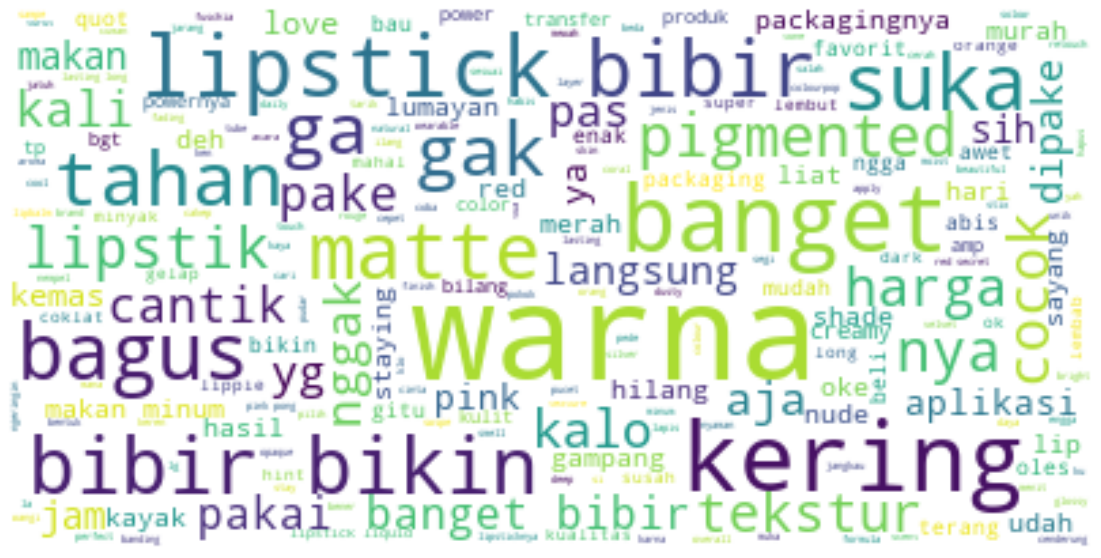

In [ ]:
word_cloud(m_stemming_stopword_ina['crossval_detail']['price_human_label']['data'][0][0]['text'])

####Packaging

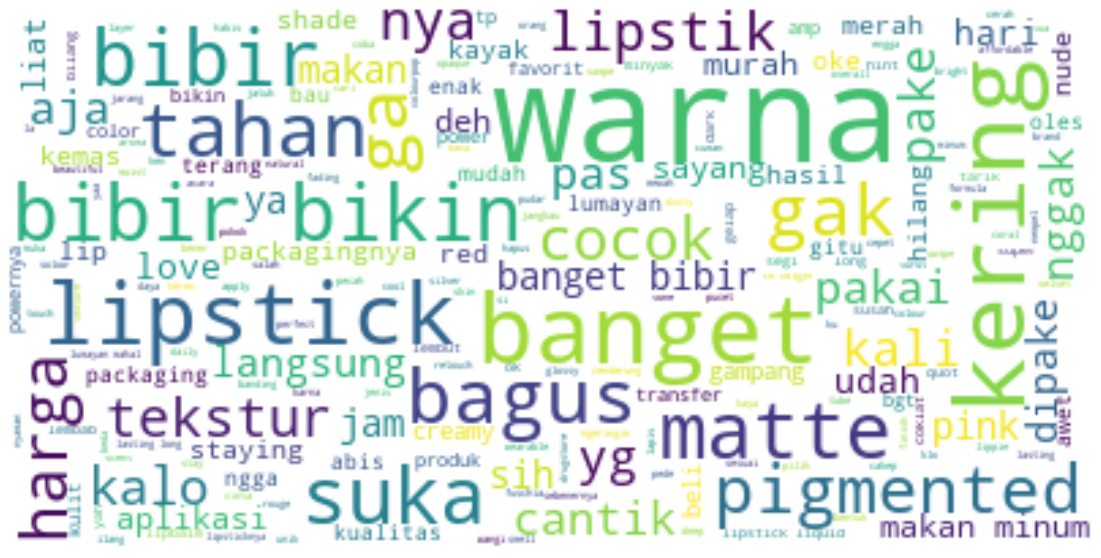

In [ ]:
word_cloud(m_stemming_stopword_ina['crossval_detail']['packaging_human_label']['data'][0][0]['text'])

####Color

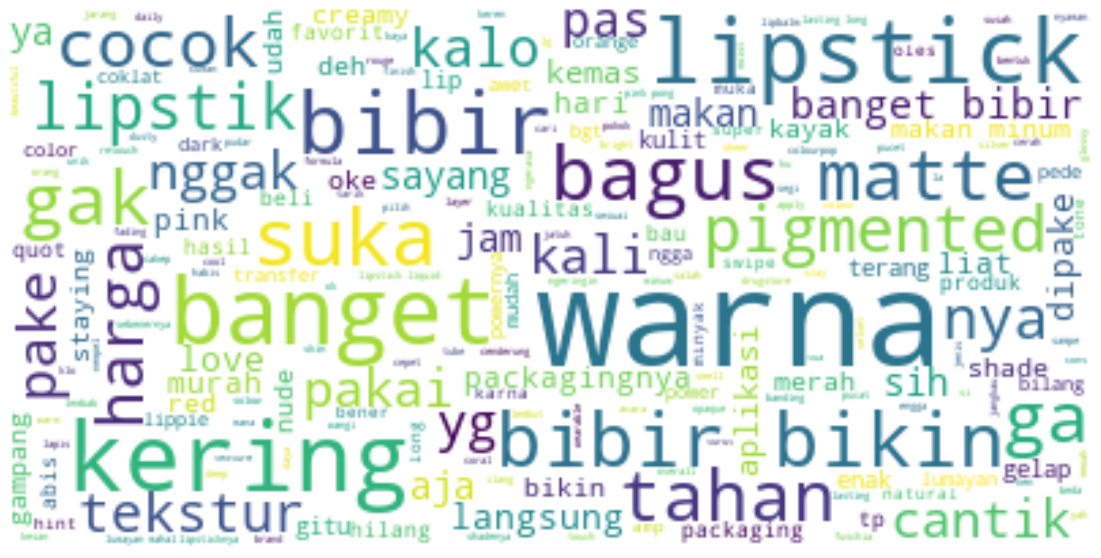

In [ ]:
word_cloud(m_stemming_stopword_ina['crossval_detail']['color_human_label']['data'][0][0]['text'])

####**Pigmented**

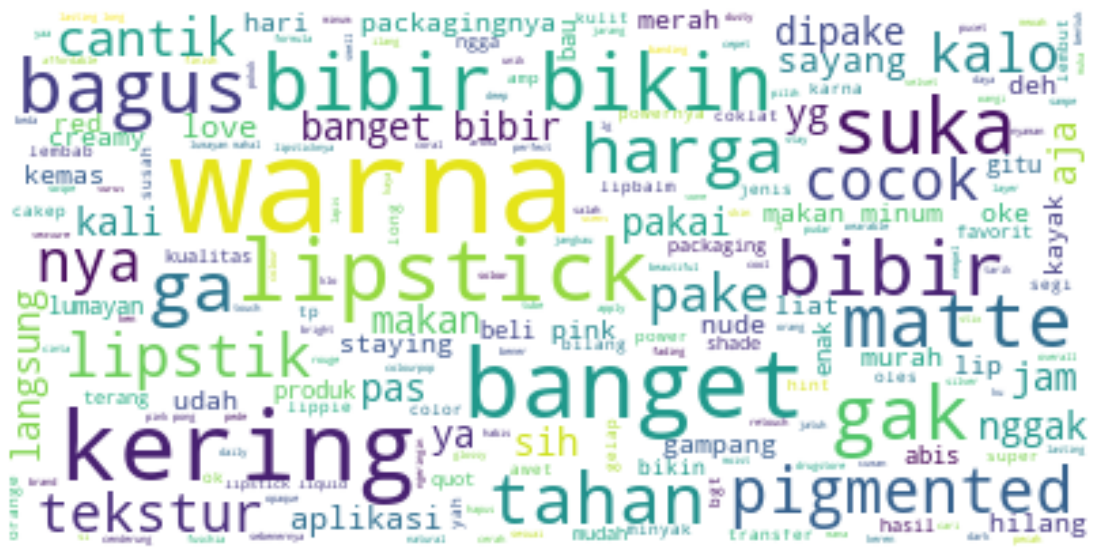

In [ ]:
word_cloud(m_stemming_stopword_ina['crossval_detail']['pigmented_human_label']['data'][0][0]['text'])

####Staying Power

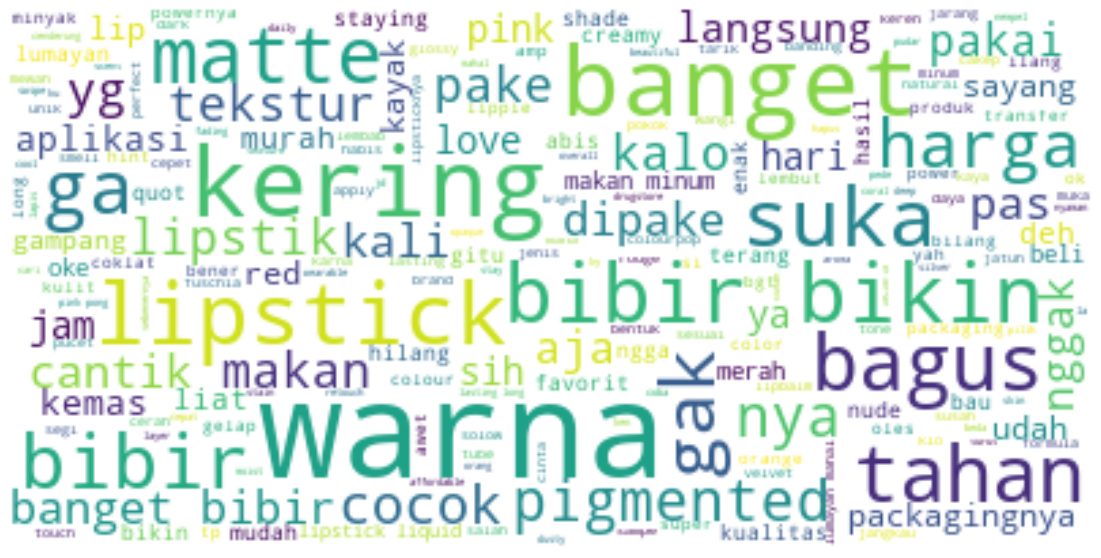

In [ ]:
word_cloud(m_stemming_stopword_ina['crossval_detail']['staying_power_human_label']['data'][0][0]['text'])

####Moist

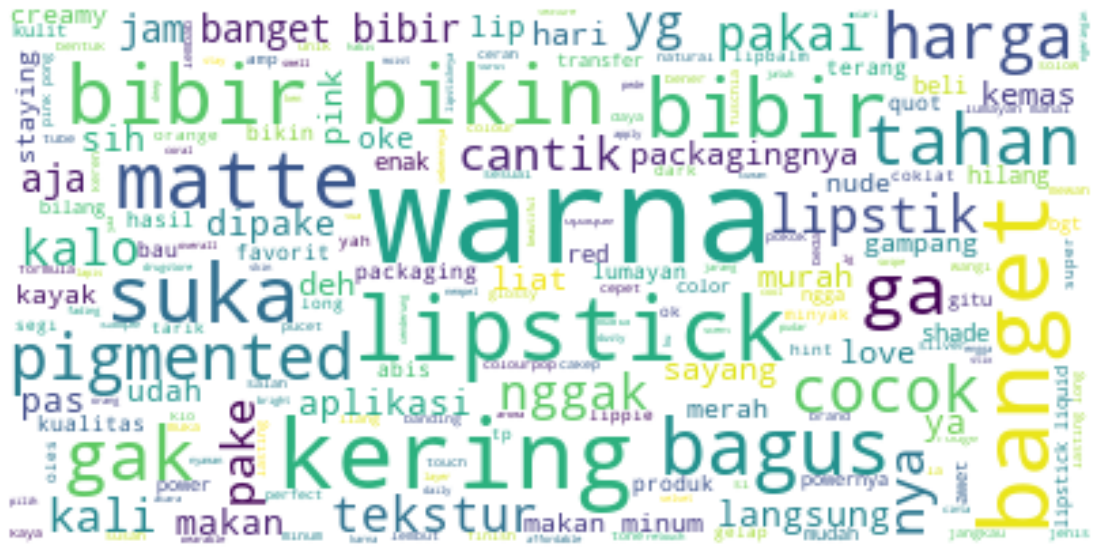

In [ ]:
word_cloud(m_stemming_stopword_ina['crossval_detail']['moist_human_label']['data'][0][0]['text'])

####Aroma

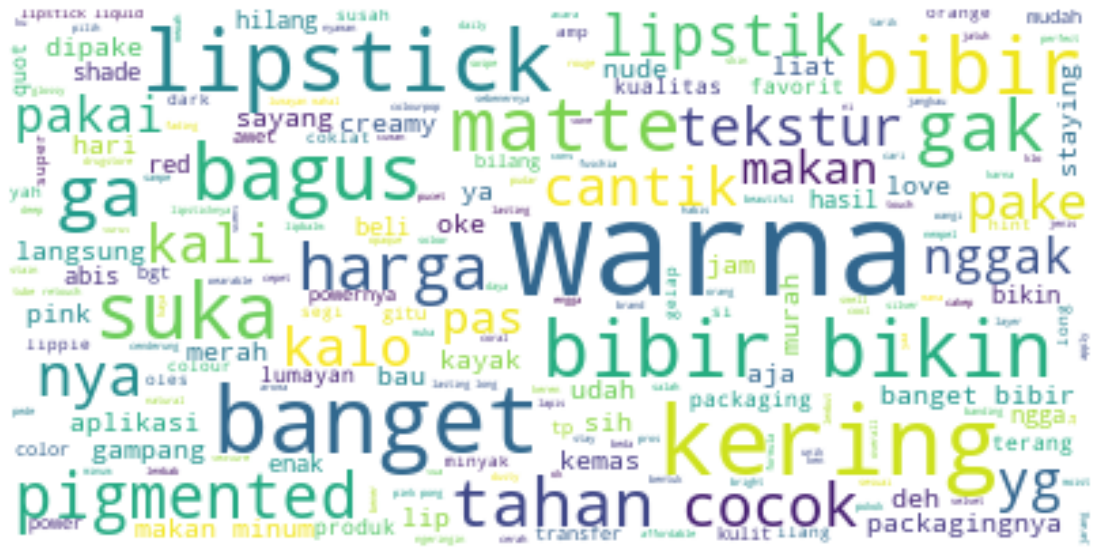

In [ ]:
word_cloud(m_stemming_stopword_ina['crossval_detail']['aroma_human_label']['data'][0][0]['text'])

## Predict New Word

In [ ]:
models = train_all_model(df_review_human_stemming_stopword_ina,human_col)

In [ ]:
filename = 'model_stemming_stopword_ina.sav'
pickle.dump(models, open(filename, 'wb'))

In [ ]:
models = '/content/model_stemming_stopword_ina.sav'
pickle.load(open(models,'rb'))

{'count': CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                 lowercase=False, max_df=1.0, max_features=None, min_df=1,
                 ngram_range=(1, 1), preprocessor=None, stop_words=None,
                 strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                 tokenizer=<function identity_tokenizer at 0x7fe9b8ddd048>,
                 vocabulary=None),
 'models': {'aroma_human_label': <__main__.Multinomial_NB at 0x7fe9b4e2fb38>,
  'color_human_label': <__main__.Multinomial_NB at 0x7fe9b5e0c5f8>,
  'moist_human_label': <__main__.Multinomial_NB at 0x7fe9b5247940>,
  'packaging_human_label': <__main__.Multinomial_NB at 0x7fe9b61a5400>,
  'pigmented_human_label': <__main__.Multinomial_NB at 0x7fe9b59f48d0>,
  'price_human_label': <__main__.Multinomial_NB at 0x7fe9b65719b0>,
  'staying_power_human_label': <__main__.Multinomial_NB at 0x7fe9b55dcba8>}}

In [ ]:
def predict(model,vectorizer,text):
  text = re.split('(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s',text)
  text = pd.Series([i for i in text if i])
  text = preprocessing_stemming_stopword_ina(text)
  for sent in text:
    c = vectorizer.transform([sent]).toarray()
    print('\n ====================================================== \n')
    print('Review Sentence: '+' '.join(sent))
    res = pd.DataFrame(index=human_col,columns=['label'])
    for cat in human_col:
      pred = model['models'][cat].predict(c)
      if int(pred) == 0:
        l = 'Negative'
      elif int(pred) == 1:
        l = 'Positive'
      else:
        l = 'Unknown'
      res.loc[cat,'label'] = l
    display(res)

In [ ]:
text = str(input())
text = re.split('(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s',text)
text = pd.Series([i for i in text if i])
prep = preprocessing_stemming_stopword_ina(text)
for sent in prep:
    print('\n ====================================================== \n')
    print('Review Sentence: '+' '.join(sent))

lipstick andalanku waktu kuliah dia warnanya natural gitu di bibir aku jadi bikin kesan fresh di muka. dia gampang bgt di pake dan ga bikin bibir jadi kering malah bisa ngelembabin gitu aku ngerasanya. biasanya aku ombre pake liptint di aku bagus bgt😍


Review Sentence: lipstick andal kuliah warna natural gitu bibir bikin kesan fresh muka


Review Sentence: gampang bgt pake ga bikin bibir kering ngelembabin gitu ngerasanya


Review Sentence: ombre pake liptint bagus bgt


In [ ]:
text = str(input())
text = re.split('(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s',text)
text = pd.Series([i for i in text if i])
prep = preprocessing_stemming_stopword_ina(text)
for sent in prep:
    print('\n ====================================================== \n')
    print('Review Sentence: '+' '.join(sent))

ini lipstick favorit, meskipun matte tapi klo dipulas di bibir ga begitu matte dan moist. yang pastinya ga bikin bibir kering. banyak pilihan warnanya yang aku suka juga. dan harganya juga juga worthy deh


Review Sentence: lipstick favorit matte klo pulas bibir ga matte moist


Review Sentence: pasti ga bikin bibir kering


Review Sentence: pilih warna suka


Review Sentence: harga worthy deh


In [ ]:
test = str(input())
predict(models,models['count'],test)

Suka banget sama tekstur creamy mattenya make over, warnanya pigmented dan ga bikin bibir kering juga. Hampir cobain banyak shadenya lipcream make over, warna ini termasuk warna yg bagus bangett buat dijadiin base ombre. Dipakein sebibir juga hasilnya ttp bagus, di skintone aku ga terlalu pucat dan kayak warna bibir aja


Review Sentence: suka banget sama tekstur creamy mattenya make over warna pigmented dan ga bikin bibir kering juga


label
price_human_label           Unknown
packaging_human_label       Unknown
color_human_label           Unknown
pigmented_human_label      Positive
staying_power_human_label   Unknown
moist_human_label          Positive
aroma_human_label           Unknown



Review Sentence: hampir cobain banyak shadenya lipcream make over warna ini masuk warna yg bagus bangett buat dijadiin base ombre


label
price_human_label          Unknown
packaging_human_label      Unknown
color_human_label          Unknown
pigmented_human_label      Unknown
staying_power_human_label  Unknown
moist_human_label          Unknown
aroma_human_label          Unknown



Review Sentence: dipakein bibir juga hasil ttp bagus di skintone aku ga terlalu pucat dan kayak warna bibir aja


label
price_human_label           Unknown
packaging_human_label       Unknown
color_human_label          Positive
pigmented_human_label       Unknown
staying_power_human_label   Unknown
moist_human_label           Unknown
aroma_human_label           Unknown

In [ ]:
test = str(input())
predict(models,models['count'],test)

Lipstick ini warnanya oke dan cukup pigmented, also less oily. Recomended banget buat pemakaian sehari-hari karena tekstur yang ringan nggak berasa berat. Cuma agak kurang suka dengan packagingnya yang menurutku kurang anak muda. 


Review Sentence: lipstick ini warna oke dan cukup pigmented also less oily


label
price_human_label           Unknown
packaging_human_label       Unknown
color_human_label           Unknown
pigmented_human_label      Positive
staying_power_human_label  Positive
moist_human_label           Unknown
aroma_human_label           Unknown



Review Sentence: recomended banget buat pakai hari hari karena tekstur yang ringan nggak asa berat


label
price_human_label          Unknown
packaging_human_label      Unknown
color_human_label          Unknown
pigmented_human_label      Unknown
staying_power_human_label  Unknown
moist_human_label          Unknown
aroma_human_label          Unknown



Review Sentence: cuma agak kurang suka dengan packagingnya yang turut kurang anak muda


label
price_human_label           Unknown
packaging_human_label      Positive
color_human_label          Positive
pigmented_human_label       Unknown
staying_power_human_label   Unknown
moist_human_label           Unknown
aroma_human_label           Unknown

In [ ]:
test = str(input())
predict(models,models['count'],test)

warnanya bagus. kalem gitu warnanya. jadi kalau di pakai sehari-hari nggak kelihatan mencolok tapi tetep kelihatan fresh dan nggak pucet. harganya standar ya menurutku, mudah ditemukan dimana saja. hasilnya juga matte bagus.sayangnya bikin kering di bibirku.


Review Sentence: warna bagus


label
price_human_label          Positive
packaging_human_label      Positive
color_human_label          Negative
pigmented_human_label      Negative
staying_power_human_label  Negative
moist_human_label           Unknown
aroma_human_label          Negative



Review Sentence: kalem gitu warna


label
price_human_label           Unknown
packaging_human_label       Unknown
color_human_label          Negative
pigmented_human_label      Negative
staying_power_human_label  Positive
moist_human_label           Unknown
aroma_human_label           Unknown



Review Sentence: jadi kalau di pakai hari hari nggak lihat colok tapi tetep lihat fresh dan nggak pucet


label
price_human_label           Unknown
packaging_human_label       Unknown
color_human_label          Positive
pigmented_human_label       Unknown
staying_power_human_label   Unknown
moist_human_label           Unknown
aroma_human_label           Unknown



Review Sentence: harga standar ya turut mudah temu mana saja


label
price_human_label          Positive
packaging_human_label       Unknown
color_human_label           Unknown
pigmented_human_label       Unknown
staying_power_human_label   Unknown
moist_human_label           Unknown
aroma_human_label           Unknown



Review Sentence: hasil juga matte bagus sayang bikin kering di bibir


label
price_human_label           Unknown
packaging_human_label       Unknown
color_human_label           Unknown
pigmented_human_label       Unknown
staying_power_human_label   Unknown
moist_human_label          Positive
aroma_human_label           Unknown

In [ ]:
test = str(input())
predict(models,models['count'],test)

ini lipstick favorit, meskipun matte tapi klo dipulas di bibir ga begitu matte dan moist. yang pastinya ga bikin bibir kering. banyak pilihan warnanya yang aku suka juga. dan harganya juga juga worthy deh


Review Sentence: ini lipstick favorit meski matte tapi klo pulas di bibir ga begitu matte dan moist


label
price_human_label           Unknown
packaging_human_label       Unknown
color_human_label           Unknown
pigmented_human_label       Unknown
staying_power_human_label   Unknown
moist_human_label          Positive
aroma_human_label           Unknown



Review Sentence: yang pasti ga bikin bibir kering


label
price_human_label           Unknown
packaging_human_label       Unknown
color_human_label           Unknown
pigmented_human_label       Unknown
staying_power_human_label   Unknown
moist_human_label          Positive
aroma_human_label           Unknown



Review Sentence: banyak pilih warna yang aku suka juga


label
price_human_label          Positive
packaging_human_label       Unknown
color_human_label           Unknown
pigmented_human_label       Unknown
staying_power_human_label  Positive
moist_human_label           Unknown
aroma_human_label           Unknown



Review Sentence: dan harga juga juga worthy deh


label
price_human_label          Positive
packaging_human_label      Positive
color_human_label           Unknown
pigmented_human_label      Positive
staying_power_human_label  Negative
moist_human_label           Unknown
aroma_human_label          Positive

In [ ]:
test = str(input())
predict(models,models['count'],test)

lipstick andalanku waktu kuliah dia warnanya natural gitu di bibir aku jadi bikin kesan fresh di muka. dia gampang bgt di pake dan ga bikin bibir jadi kering malah bisa ngelembabin gitu aku ngerasanya. biasanya aku ombre pake liptint di aku bagus bgt😍


Review Sentence: lipstick andal waktu kuliah dia warna natural gitu di bibir aku jadi bikin kesan fresh di muka


label
price_human_label           Unknown
packaging_human_label       Unknown
color_human_label          Positive
pigmented_human_label       Unknown
staying_power_human_label   Unknown
moist_human_label           Unknown
aroma_human_label           Unknown



Review Sentence: dia gampang bgt di pake dan ga bikin bibir jadi kering malah bisa ngelembabin gitu aku ngerasanya


label
price_human_label           Unknown
packaging_human_label       Unknown
color_human_label           Unknown
pigmented_human_label       Unknown
staying_power_human_label   Unknown
moist_human_label          Negative
aroma_human_label           Unknown



Review Sentence: biasa aku ombre pake liptint di aku bagus bgt


label
price_human_label          Positive
packaging_human_label      Positive
color_human_label          Negative
pigmented_human_label      Positive
staying_power_human_label  Positive
moist_human_label           Unknown
aroma_human_label          Negative

In [ ]:
test = str(input())
predict(models,models['count'],test)

Dari lipstick saya yg berjumlah sangat banyak, hanya satu lipstick ini yg saya habiskan sampai tandas.. Seumur-umur baru kali ini repurchase lipstick dengan warna yang sama.. Yah, sesuka itu saya dengan warna lipstick ini.. Bener2 cocok dengan skintone saya, ga norak dan warnanya cantik sekali.. Formulanya juga bagus banget, ga bikin bibir kering padahal dia teksturnya matte.. Kemasannya lama ini juga terkesan mahal.. Kalau mapple mocca saya yang kedua ini habis lagi, pasti saya akan membeli kembali lagi..


Review Sentence: dari lipstick saya yg jumlah sangat banyak hanya satu lipstick ini yg saya habis sampai tandas


label
price_human_label          Positive
packaging_human_label       Unknown
color_human_label           Unknown
pigmented_human_label       Unknown
staying_power_human_label   Unknown
moist_human_label           Unknown
aroma_human_label           Unknown



Review Sentence: umur umur baru kali ini repurchase lipstick dengan warna yang sama


label
price_human_label           Unknown
packaging_human_label       Unknown
color_human_label          Positive
pigmented_human_label      Negative
staying_power_human_label   Unknown
moist_human_label           Unknown
aroma_human_label           Unknown



Review Sentence: yah suka itu saya dengan warna lipstick ini


label
price_human_label           Unknown
packaging_human_label       Unknown
color_human_label          Positive
pigmented_human_label       Unknown
staying_power_human_label   Unknown
moist_human_label           Unknown
aroma_human_label           Unknown



Review Sentence: bener cocok dengan skintone saya ga norak dan warna cantik sekali


label
price_human_label           Unknown
packaging_human_label       Unknown
color_human_label          Positive
pigmented_human_label       Unknown
staying_power_human_label   Unknown
moist_human_label           Unknown
aroma_human_label           Unknown



Review Sentence: formula juga bagus banget ga bikin bibir kering padahal dia tekstur matte


label
price_human_label           Unknown
packaging_human_label       Unknown
color_human_label          Positive
pigmented_human_label       Unknown
staying_power_human_label   Unknown
moist_human_label          Negative
aroma_human_label           Unknown



Review Sentence: kemas lama ini juga kes mahal


label
price_human_label          Negative
packaging_human_label      Negative
color_human_label           Unknown
pigmented_human_label       Unknown
staying_power_human_label   Unknown
moist_human_label           Unknown
aroma_human_label           Unknown



Review Sentence: kalau mapple mocca saya yang dua ini habis lagi pasti saya akan beli kembali lagi


label
price_human_label           Unknown
packaging_human_label       Unknown
color_human_label          Positive
pigmented_human_label       Unknown
staying_power_human_label   Unknown
moist_human_label           Unknown
aroma_human_label           Unknown

###Count words in a class

In [ ]:
def calculate_word(df,word,aspect):
  pos = 0
  neg = 0
  unk = 0
  for idx,row in df.iterrows():
    if row[aspect]==0:
      neg += row['reviee_sent'].count(word)
    elif row[aspect]==1:
      pos += row['reviee_sent'].count(word)
    else:
      unk += row['reviee_sent'].count(word)
  print(f'pos: {pos}\nneg: {neg}\nunk: {unk}')

In [ ]:
calculate_word(df_review_human_stemming_stopword_ina,'murah','price_human_label_enc')

pos: 30
neg: 8
unk: 3


In [ ]:
calculate_word(df_review_human_stemming_stopword_ina,'warna','moist_human_label_enc')

pos: 83
neg: 28
unk: 590


In [ ]:
calculate_word(df_review_human_stemming_stopword_ina,'packagingnya','packaging_human_label_enc')

pos: 41
neg: 9
unk: 2


In [ ]:
calculate_word(df_review_human_stemming_stopword_ina,'packaging','price_human_label_enc')

pos: 2
neg: 0
unk: 31
